In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Load libraries for Decision Tree
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# Load libraries for Decision Tree Model Plot
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

# Load libaries for various model performance metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve
from matplotlib import pyplot as plt
from inspect import signature

# Load libaries for logistic regression
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set()
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

In [4]:
# DATA IMPORT
data = pd.read_csv('creditcard.csv',sep=',')
data.head()

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [14]:
# DATA PREPARATION
is_fraud = data.Class
prepared_data = data.drop(columns=['Class'])
prepared_data.insert(0, 'is_fraud', is_fraud)

In [15]:
# STRUCTURE DATA SUCH THAT FIRST COLUMN IS LABEL AND REST OF COLUMNS ARE FEATURES

In [57]:
def unlabel_partition(data):
    labeled = data.sample(frac = 0.5, random_state = 200)
    unlabeled = data.drop(labeled.index)
    
    return labeled, unlabeled

def partition_to_delete(labeled):
    keep = labeled.sample(frac=0.9, random_state = 100)
    delete = labeled.drop(keep.index)
    
    return keep, delete

def split_test_train(data):
    train = data.sample(frac=0.8,random_state=150) #random state is a seed value
    test = data.drop(train.index)
    
    train_y = train.iloc[:,0]
    train_x = train.drop(train.columns[0], axis=1)
    
    test_y = test.iloc[:,0]
    test_x = test.drop(test.columns[0], axis=1)

    return train_x, train_y, test_x, test_y

def train_tree(data):    
    train_x, train_y, test_x, test_y = split_test_train(data)
    
    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier(min_samples_leaf = 5, min_impurity_decrease = 0.000001)

    # Train Decision Tree Classifer
    clf = clf.fit(train_x,train_y)

    #Predict the response for test dataset
    predict_y = clf.predict(test_x)
    
    feature_names = train_x.columns
    class_names = train_y.unique()
    
    #plot_tree(clf, feature_names, class_names)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(test_y, predict_y))
    print(confusion_matrix(test_y, predict_y))
    plot_ROC(clf, test_x, test_y)
    plot_tree(clf, feature_names, class_names)
    
    y_scores = clf.predict_proba(test_x)[:,1]

    
    average_precision = average_precision_score(test_y, y_scores)
    print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
    
    precision, recall, _ = precision_recall_curve(test_y, y_scores)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))

def plot_tree(clf, feature_names, class_names):
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names = feature_names,class_names=['0','1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png('tree.png')
    display(Image(graph.create_png()))
    
def plot_tree_ROC(clf, test_x, test_y):
    prob_predictions = clf.predict_proba(test_x)
    print('AUC: ' + str(roc_auc_score(test_y, prob_predictions[:,1])))

    fpr, tpr, _ = roc_curve(test_y, prob_predictions[:,1])

    plt.clf()
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
def train_logistic_regression(data):
    train_x, train_y, test_x, test_y = split_test_train(data)

    lr = LogisticRegression()
        
    lr.fit(train_x, train_y)
    
    print(lr.coef_)
    print(lr.intercept_)
    
    predict_y = lr.predict(test_x)
    print(confusion_matrix(test_y, predict_y))
    
def main(data):
    labeled, unlabeled = unlabel_partition(data)
    train_tree(labeled)
    train_logistic_regression(labeled)

Accuracy: 0.9992626663389628
[[28419    11]
 [   10    41]]
AUC: 0.9312497844723538


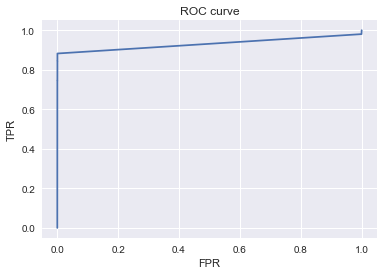

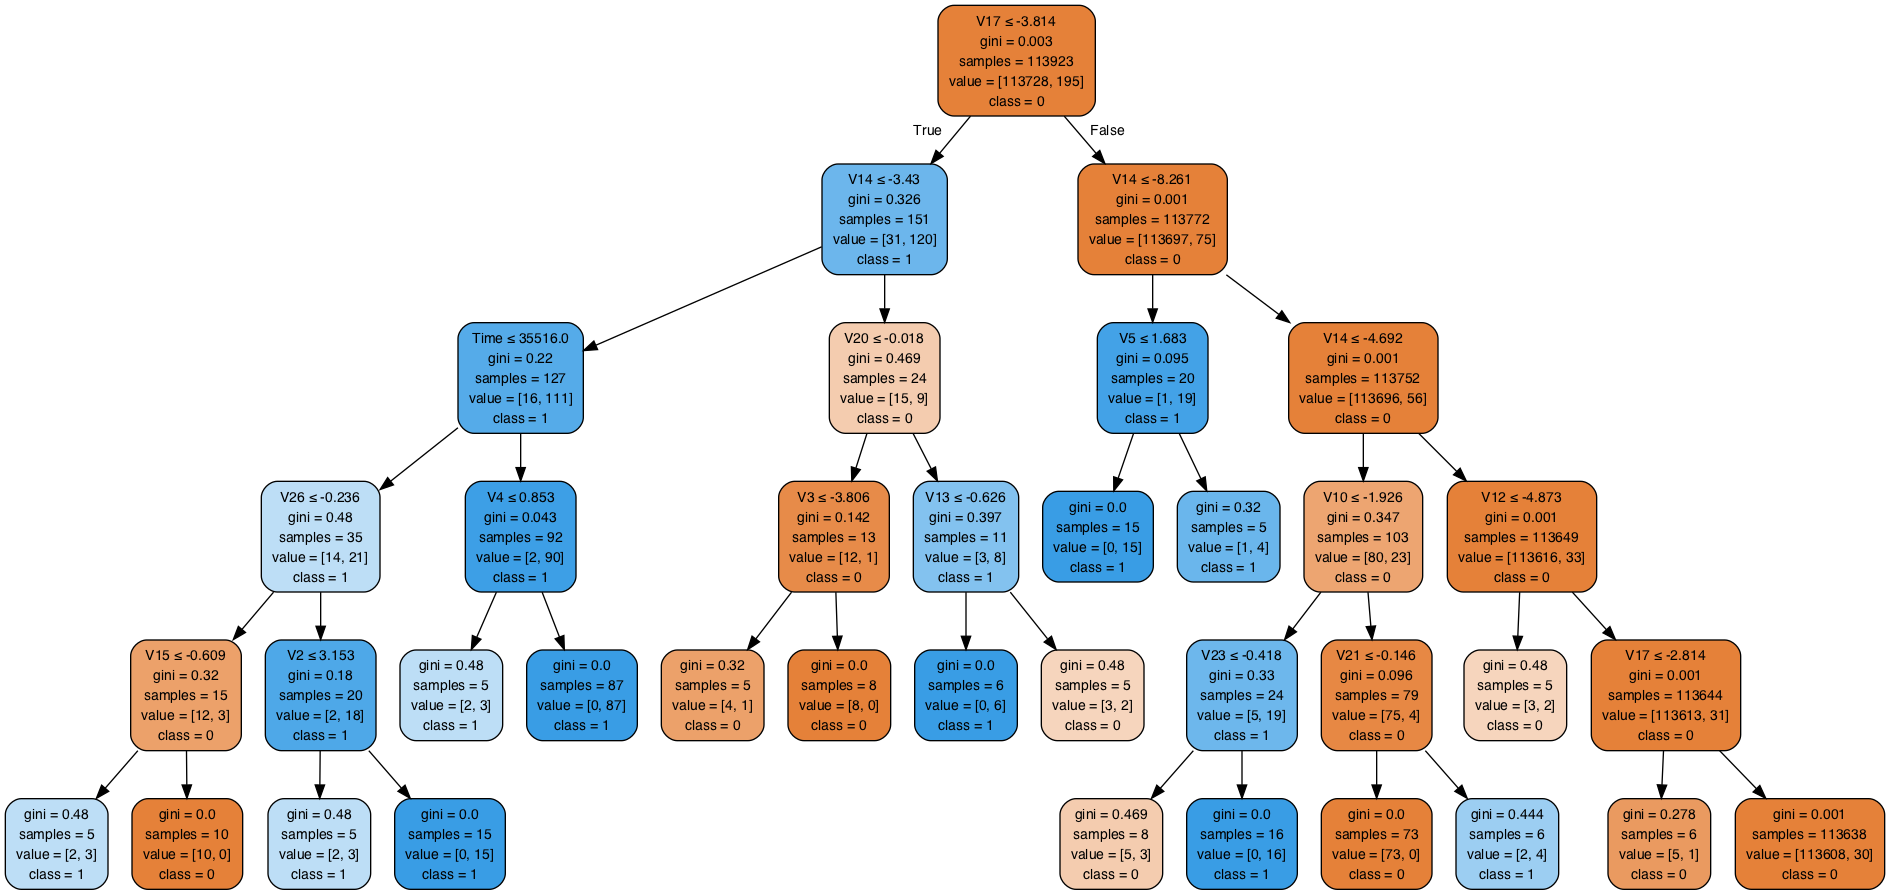

Average precision-recall score: 0.75
[[-9.18379631e-05  1.01112381e-01 -2.39362009e-01 -6.22746557e-01
   1.38724735e-01 -3.67548997e-02 -7.05981054e-02 -1.39173255e-02
  -4.45737094e-02 -3.36889785e-01 -1.82940290e-01 -9.12133974e-02
   9.15483352e-03 -2.25536151e-01 -6.16468136e-01 -1.26095918e-01
  -2.07662264e-01 -3.61303732e-01 -1.38991379e-02  6.43120471e-02
   2.69917491e-02  8.82716302e-02  1.25319866e-01  1.88070692e-02
  -2.57435111e-02 -9.00183442e-02  1.10614148e-02 -2.48635129e-02
   2.28019269e-02 -9.35404363e-03]]
[-0.61137762]
[[28414    16]
 [   19    32]]


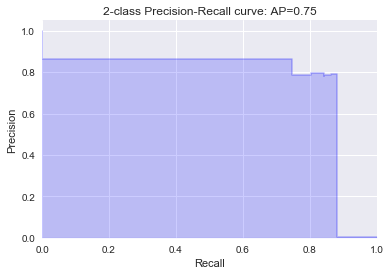

In [58]:
main(prepared_data)